# Simple Jax (haiku optimized) NN from Scratch

Haiku is a deep learning library designed for Jax. It provides a set of tools that make defining models and handling initialization and paramater updates much easier. In this notebook we show how to optimize a simple Haiku model using jax.jit to achieve optimal performance.


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jax.numpy as jnp
import haiku as hk
from functools import partial
import jax
from jax import random
from jax import nn
from jax import vmap
from jax import grad

In [2]:
data_df = pd.read_csv('./digit-recognizer/train.csv')

In [3]:
np.random.shuffle(data_df.values)
m, n = data_df.shape
Y = jnp.array(data_df["label"])
data_df = data_df.drop("label", axis=1)
X = jnp.array(data_df)


X_train = X[1000:]
X_train = X_train / 255.
Y_train = Y[1000:]

X_val = X[:1000]
X_val = X_val / 255.
Y_val = Y[:1000]

Our NN will have a simple two-layer architecture. Input layer $A^{[0]}$ will have 784 units corresponding to the 784 pixels in each 28x28 input image. A hidden layer $A^{[1]}$ will have 10 units with ReLU activation, and finally our output layer $A^{[2]}$ will have 10 units corresponding to the ten digit classes with softmax activation.


**Forward propagation**

Input Layer:    
$$X = A^{[0]}$$

First Hidden Layer:
$$Z^{[1]} = W^{[1]} X + b^{[1]}$$
$$A^{[1]} = g_{\text{ReLU}}(Z^{[1]})$$

Second Hidden Layer:
$$Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}$$
$$A^{[2]} = g_{\text{softmax}}(Z^{[2]})$$

**Backward propagation**

Loss Function (Categorical Cross Entropy):  
$$L(y, a^{[2]}) = -\sum_{j = 1}^{C}y_{j} \cdot\ log(a^{[2]})$$ 
C is the number of classes, which is 10 in this case. 

Cost Function:
$$J(W, b) = -\frac{1}{m} \sum_{i = 1}^{m} L(y^{i}, a^{[2](i)})$$ 
$$J(W, b) = -\frac{1}{m} \sum_{i = 1}^{m} \sum_{j = 1}^{C}y^{i}_{j}\cdot\log(a^{[2](i)})$$ 
The cost function is the average of the losses over all the samples.

Derivatives:    
For detailed derivation of $dZ^{[2]}$ see: [derivation-of-categorical-cross-entropy-loss](https://towardsdatascience.com/derivative-of-the-softmax-function-and-the-categorical-cross-entropy-loss-ffceefc081d1)    
For more details on the rest of the derivations see: [backpropagation-intuition](https://www.youtube.com/watch?v=yXcQ4B-YSjQ&list=PLkDaE6sCZn6Ec-XTbcX1uRg2_u4xOEky0&index=34&ab_channel=DeepLearningAI)
$$dZ^{[2]} = A^{[2]} - Y$$
$$dW^{[2]} = \frac{1}{m} dZ^{[2]} A^{[1]T}$$
$$dB^{[2]} = \frac{1}{m} \sum_{i = 1}^{m} {dZ^{[2]}}$$
$$dZ^{[1]} = W^{[2]T} dZ^{[2]} .* g^{[1]\prime} (z^{[1]})$$
$$dW^{[1]} = \frac{1}{m} dZ^{[1]} A^{[0]T}$$
$$dB^{[1]} = \frac{1}{m} \sum_{i = 1}^{m} {dZ^{[1]}}$$

**Gradient Descent (parameter updates)**

$$W^{[2]} := W^{[2]} - \alpha dW^{[2]}$$
$$b^{[2]} := b^{[2]} - \alpha db^{[2]}$$
$$W^{[1]} := W^{[1]} - \alpha dW^{[1]}$$
$$b^{[1]} := b^{[1]} - \alpha db^{[1]}$$

**Vars and shapes**

Forward prop

- $A^{[0]} = X$: 784 x m
- $Z^{[1]} \sim A^{[1]}$: 10 x m
- $W^{[1]}$: 10 x 784 (as $W^{[1]} A^{[0]} \sim Z^{[1]}$)
- $B^{[1]}$: 10 x 1
- $Z^{[2]} \sim A^{[2]}$: 10 x m
- $W^{[1]}$: 10 x 10 (as $W^{[2]} A^{[1]} \sim Z^{[2]}$)
- $B^{[2]}$: 10 x 1

Backprop

- $dZ^{[2]}$: 10 x m ($~A^{[2]}$)
- $dW^{[2]}$: 10 x 10
- $dB^{[2]}$: 10 x 1
- $dZ^{[1]}$: 10 x m ($~A^{[1]}$)
- $dW^{[1]}$: 10 x 10
- $dB^{[1]}$: 10 x 1

The layers and activation functions can now be defined using Haiku's functions. No need to explicitly specify the weights and biases of each layer.

In [4]:
def _forward_fn(x):
    mlp = hk.Sequential([
        hk.Linear(10), jax.nn.relu,
        hk.Linear(10), jax.nn.softmax
    ])
    return mlp(x)

The Haiku model above is an object, not a pure function, which is required for Jax's. So the model is first transformed using the hk.transform method.

In [28]:
forward_fn = hk.transform(_forward_fn)

The models layers shown below, are the same as used in previous notebooks.

In [6]:
dummy_x = X_train[:5]
rng_key = random.PRNGKey(64)

initial_params = forward_fn.init(rng=rng_key, x=dummy_x)

for layer_name, weights in initial_params.items():
    print(layer_name)
    print("Weights : {}, Biases : {}\n".format(initial_params[layer_name]["w"].shape, initial_params[layer_name]["b"].shape))

linear
Weights : (784, 10), Biases : (10,)

linear_1
Weights : (10, 10), Biases : (10,)



The model can process a batch of any size.

In [7]:
preds = forward_fn.apply(initial_params, rng_key, X_train[:5])
print(preds)

[[0.10903449 0.08148836 0.11404355 0.11746839 0.08617248 0.1121618
  0.07521552 0.11107448 0.10700246 0.08633839]
 [0.1184034  0.0760287  0.12359262 0.10440519 0.07472834 0.09813596
  0.06421445 0.12048039 0.12889716 0.09111377]
 [0.11008009 0.07168338 0.11888898 0.09912661 0.07042118 0.09882687
  0.06582631 0.13413298 0.12996739 0.10104617]
 [0.11240921 0.07807808 0.11019351 0.09632948 0.08014824 0.09616168
  0.08019723 0.12127028 0.12024726 0.10496502]
 [0.1098324  0.09535951 0.12875696 0.10512744 0.09696282 0.09774043
  0.08459642 0.10147075 0.10227625 0.07787712]]


The forward pass performed in the loss function now needs the .apply method. The explicit weights, biases and gradients have been replaced by params and grads in the update_params function. This saves a lot of code on more complex models.

In [9]:
@partial(jax.jit, static_argnames=['k'])
def one_hot(x, k, dtype=jnp.float32):
    """Create a one-hot encoding of x of size k."""
    return jnp.array(x[:, None] == jnp.arange(k), dtype)

@jax.jit
def loss_fn(params, X, Y):
    A2 = forward_fn.apply(params, rng_key, X)
    one_hot_Y = one_hot(Y, 10)
    loss = -jnp.sum(one_hot_Y * jnp.log(A2)) / m
    return loss

@jax.jit
def update_rule(param, update):
    return param - 0.1 * update

@jax.jit
def update_params(params, alpha, X, Y):
    grads = grad(loss_fn, argnums=0)(params, X, Y)
    params = jax.tree_util.tree_map(update_rule, params, grads)
    return params


The initialization function has been removed since Haiku handles the initialization using the .init method.

In [10]:
@jax.jit
def get_predictions(A2):
    return jnp.argmax(A2, axis=1)

def get_accuracy(predictions, Y):
    print(predictions, Y)
    return jnp.mean(predictions == Y)

def gradient_descent(X, Y, alpha, iterations):
    rng = jax.random.PRNGKey(42)
    params = forward_fn.init(rng=rng, x=X)
    for i in range(iterations):
        params = update_params(params, alpha, X, Y)
        if i % 10 == 0:
            print("Iteration: ", i)
            A2 = forward_fn.apply(params, rng, X)
            predictions = get_predictions(A2)
            print(get_accuracy(predictions, Y))
    return params

In [15]:
params = gradient_descent(X_train, Y_train, 0.10, 500)

Iteration:  0
[8 1 1 ... 8 1 8] [2 4 8 ... 5 5 4]
0.16009755
Iteration:  10
[1 4 1 ... 8 8 5] [2 4 8 ... 5 5 4]
0.3594878
Iteration:  20
[1 4 3 ... 8 8 4] [2 4 8 ... 5 5 4]
0.59985363
Iteration:  30
[1 4 3 ... 9 0 9] [2 4 8 ... 5 5 4]
0.6919756
Iteration:  40
[2 4 3 ... 9 0 4] [2 4 8 ... 5 5 4]
0.7266829
Iteration:  50
[2 4 3 ... 9 6 4] [2 4 8 ... 5 5 4]
0.7523171
Iteration:  60
[2 4 8 ... 9 6 4] [2 4 8 ... 5 5 4]
0.7767073
Iteration:  70
[2 4 8 ... 5 6 4] [2 4 8 ... 5 5 4]
0.79614633
Iteration:  80
[2 4 8 ... 5 6 4] [2 4 8 ... 5 5 4]
0.8119268
Iteration:  90
[2 4 8 ... 5 6 4] [2 4 8 ... 5 5 4]
0.82387805
Iteration:  100
[2 4 8 ... 5 6 4] [2 4 8 ... 5 5 4]
0.83412194
Iteration:  110
[2 4 8 ... 5 6 4] [2 4 8 ... 5 5 4]
0.84156096
Iteration:  120
[2 4 8 ... 5 6 4] [2 4 8 ... 5 5 4]
0.8484146
Iteration:  130
[2 4 8 ... 5 6 4] [2 4 8 ... 5 5 4]
0.8546097
Iteration:  140
[2 4 8 ... 5 6 4] [2 4 8 ... 5 5 4]
0.8593658
Iteration:  150
[2 4 8 ... 5 6 4] [2 4 8 ... 5 5 4]
0.8631707
Iteration:  1

In [16]:
def make_predictions(X, params):
    rng = jax.random.PRNGKey(42)
    A2 = forward_fn.apply(params, rng, X)
    predictions = get_predictions(A2)
    return predictions

def test_prediction(index, params):
    current_image = X_train[None, index]
    prediction = make_predictions(X_train[None, index], params)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Prediction:  [2]
Label:  2


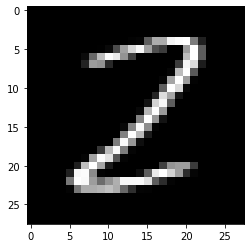

Prediction:  [4]
Label:  4


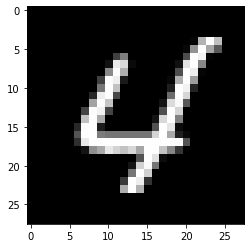

Prediction:  [3]
Label:  8


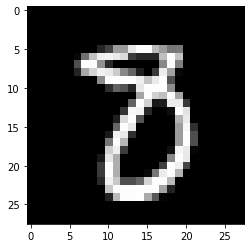

Prediction:  [7]
Label:  7


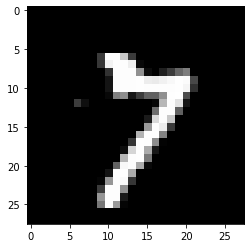

In [17]:
test_prediction(0, params)
test_prediction(1, params)
test_prediction(2, params)
test_prediction(3, params)

In [18]:
val_predictions = make_predictions(X_val, params)
get_accuracy(val_predictions, Y_val)

[6 7 1 9 8 4 5 7 7 8 4 0 4 9 7 1 8 3 6 4 7 4 2 5 7 1 0 5 2 1 6 1 1 4 9 0 4
 1 0 7 7 6 6 7 6 2 5 0 5 0 9 0 7 4 0 6 8 8 9 5 3 5 5 7 9 0 3 9 4 3 9 6 9 0
 1 3 5 2 5 7 1 8 6 8 4 7 6 9 6 7 8 6 3 3 4 4 2 3 4 2 6 1 7 0 4 9 6 7 5 6 8
 8 4 1 7 4 4 5 9 4 9 1 3 1 9 7 9 5 2 1 6 1 6 1 1 6 3 0 8 8 3 8 3 7 1 3 5 4
 2 7 3 7 5 3 9 2 5 8 4 4 6 4 2 6 1 4 8 5 6 4 1 7 2 9 6 1 8 0 3 1 9 3 6 6 6
 6 9 4 9 5 9 8 0 8 5 7 6 4 7 8 4 7 2 2 8 9 4 1 9 8 0 5 0 2 6 5 3 0 4 7 2 0
 5 2 5 0 0 1 0 8 4 5 1 6 3 0 6 1 1 6 7 1 4 6 4 8 9 4 9 7 8 4 4 7 5 6 0 1 6
 4 4 9 3 7 4 8 6 5 1 6 4 3 7 3 8 1 4 2 9 6 0 1 4 8 7 1 7 5 0 4 2 1 5 1 9 7
 9 3 6 4 3 4 2 3 1 4 8 5 3 9 3 3 8 7 4 4 3 8 5 5 8 1 6 6 3 5 5 6 4 8 7 1 4
 3 0 3 1 2 7 6 7 8 3 7 1 0 4 9 3 3 0 5 9 3 6 1 1 9 4 7 1 1 2 3 7 8 1 4 0 0
 5 9 0 7 4 8 0 9 0 2 2 4 8 3 7 0 6 6 9 4 3 4 6 9 6 1 4 6 5 8 2 0 5 3 7 1 7
 7 0 3 3 6 0 0 0 6 9 0 1 5 6 8 1 0 4 3 2 6 6 4 0 3 9 8 9 1 7 9 1 7 4 0 1 8
 6 0 6 9 8 6 6 1 3 8 3 9 6 9 5 1 0 3 4 6 1 0 6 7 0 1 7 4 8 1 7 3 2 8 4 9 1
 6 9 8 2 2 7 9 1 9 8 4 1 

DeviceArray(0.91300005, dtype=float32)

No loss in accuracy during training or inferencing compared to other methods.

In [19]:
large_X_input = X_val.copy()

for i in range(6):
    large_X_input = jnp.concatenate((large_X_input, large_X_input), axis=0)

In [20]:
large_X_input.shape

(64000, 784)

In [31]:
rng = jax.random.PRNGKey(42)
forward_opt = jax.jit(forward_fn.apply)
%timeit forward_opt(params, rng, large_X_input)

1.38 ms ± 729 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


### Conclusion

Training time for Haiku optimized vs autograd optimized was the same (1.3s vs 1.3s). Inferencing time was also the same (1.36s vs 1.38s), showing that no performance was lost by using Haiku.